In [2]:
import os

import pandas as pd
import xgboost
import optuna
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error 
import json
import joblib

logical_cores = os.cpu_count()`
print(f"Number of logical CPU cores: {logical_cores}")

num_workers = max(1, logical_cores // 2)
print(f"Number of workers set to: {num_workers}")

def is_gpu_available():
    try:
        import torch
        return torch.cuda.is_available()
    except ImportError:
        return False

gpu_available = is_gpu_available()
print(f"GPU available: {gpu_available}")

print(xgboost.build_info())



Number of logical CPU cores: 16
Number of workers set to: 8
GPU available: True
{'BUILTIN_PREFETCH_PRESENT': False, 'CUDA_VERSION': [12, 4], 'DEBUG': False, 'MM_PREFETCH_PRESENT': True, 'THRUST_VERSION': [2, 3, 2], 'USE_CUDA': True, 'USE_DLOPEN_NCCL': False, 'USE_FEDERATED': False, 'USE_NCCL': False, 'USE_OPENMP': True, 'USE_RMM': False, 'libxgboost': 'C:\\Users\\ng_mi\\Anaconda\\envs\\pytorch-gpu\\Lib\\site-packages\\xgboost\\lib\\xgboost.dll'}


In [3]:
os.makedirs('../feature-importances/xbclassifier', exist_ok=True)
os.makedirs('../feature-importances/xbregressor', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/hyperparameters-search-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/trained-models/xgboost/xbregressor', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbclassifier', exist_ok=True)
os.makedirs('../models/best-hyperparameters/xgboost/xbregressor', exist_ok=True)


path = '../data/train'

ticker_list = []

if os.path.exists(path):
    ticker_list = [os.path.splitext(f)[0] for f in os.listdir(path) if f.endswith('.csv')]


In [4]:
def load_or_create_ticker_df(csv_file_path):
    """
    Load the existing ticker DataFrame from a CSV file if it exists,
    otherwise create a new DataFrame with predefined column types.
    Ensure the DataFrame has the specified columns, add any missing columns,
    and rearrange the columns in alphabetical order, excluding 'Ticker_Symbol'.

    Args:
    csv_file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The loaded or newly created DataFrame.
    """
    # Define the column types
    column_types = {
        "Ticker_Symbol": str,
        "Best_Cov1D_Classification_Accuracy": float,
        "Best_Cov1D_Classification_Path": str,
        "Best_Cov1D_Regression_RMSE": float,
        "Best_Cov1D_Regression_Path": str,
        "Best_LSTM_Classification_Accuracy": float,
        "Best_LSTM_Classification_Path": str,
        "Best_LSTM_Regression_RMSE": float,
        "Best_LSTM_Regression_Path": str,
        "Best_Transformer_Classification_Accuracy": float,
        "Best_Transformer_Classification_Path": str,
        "Best_Transformer_Regression_RMSE": float,
        "Best_Transformer_Regression_Path": str,
        "Best_XGBClassifier_Classification_Accuracy": float,
        "Best_XGBClassifier_Classification_Path": str,
        "Best_XGBRegressor_Regression_RMSE": float,
        "Best_XGBRegressor_Regression_Path": str
    }


    if os.path.isfile(csv_file_path):
        # Load the existing file into a DataFrame
        ticker_df = pd.read_csv(csv_file_path)
        
        # Ensure all specified columns are present
        for column, dtype in column_types.items():
            if column not in ticker_df.columns:
                ticker_df[column] = pd.Series(dtype=dtype)
        
    else:
        # Create a new DataFrame with the specified column types
        ticker_df = pd.DataFrame(columns=column_types.keys()).astype(column_types)
    
    return ticker_df

In [5]:
def delete_hyperparameter_search_model(ticker_symbol, model_type):
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    xbclassifier_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    xbregressor_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    xbclassifier_params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    xbregressor_params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'

    if model_type == "xbclassifier":
        if os.path.isfile(xbclassifier_model_path):
            os.remove(xbclassifier_model_path)
            print(f"Deleted {xbclassifier_model_path}")
        if os.path.isfile(xbclassifier_params_path):
            os.remove(xbclassifier_params_path)
            print(f"Deleted {xbclassifier_params_path}")
    
    if model_type == "xbregressor":
        if os.path.isfile(xbregressor_model_path):
            os.remove(xbregressor_model_path)
            print(f"Deleted {xbregressor_model_path}")
        if os.path.isfile(xbregressor_params_path):
            os.remove(xbregressor_params_path)
            print(f"Deleted {xbregressor_params_path}")

    if os.path.isfile(csv_path):
        ticker_df = pd.read_csv(csv_path)
        if ticker_symbol in ticker_df['Ticker_Symbol'].values:
            if model_type == "xbclassifier":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [pd.NA, pd.NA]
            if model_type == "xbregressor":
                ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [pd.NA, pd.NA]
            ticker_df.to_csv(csv_path, index=False)
            print(f"Deleted {ticker_symbol} from {csv_path}")
        else:
            print(f"{ticker_symbol} not found in {csv_path}")
    else:
        print(f"{csv_path} does not exist")


In [6]:
"""
0: Date
1: Open
2: High
3: Low
4: Close
5: Adj Close
6: Volume
7: BB_UPPER
8: BB_MIDDLE
9: BB_LOWER
10: DEMA
11: EMA
12: HT_TRENDLINE
13: KAMA
14: MA
15: MAMA
16: FAMA
17: MAVP
18: MIDPOINT
19: MIDPRICE
20: SAR
21: SAREXT
22: SMA
23: T3
24: TEMA
25: TRIMA
26: WMA
27: ADX
28: ADXR
29: APO
30: AROON_down
31: AROON_up
32: AROONOSC
33: BOP
34: CCI
35: CMO
36: DX
37: MACD
38: MACD_signal
39: MACD_hist
40: MACDEXT
41: MACDEXT_signal
42: MACDEXT_hist
43: MACDFIX
44: MACDFIX_signal
45: MACDFIX_hist
46: MFI
47: MINUS_DI
48: MINUS_DM
49: MOM
50: PLUS_DI
51: PLUS_DM
52: PPO
53: ROC
54: ROCP
55: ROCR
56: ROCR100
57: RSI
58: STOCH_slowk
59: STOCH_slowd
60: STOCHF_fastk
61: STOCHF_fastd
62: STOCHRSI_fastk
63: STOCHRSI_fastd
64: TRIX
65: ULTOSC
66: WILLR
67: AD
68: ADOSC
69: OBV
70: ATR
71: NATR
72: TRANGE
73: HT_DCPERIOD
74: HT_DCPHASE
75: HT_PHASOR_inphase
76: HT_PHASOR_quadrature
77: HT_SINE_sine
78: HT_SINE_leadsine
79: HT_TRENDMODE
80: AVGPRICE
81: MEDPRICE
82: TYPPRICE
83: WCLPRICE
84: BETA
85: CORREL
86: LINEARREG
87: LINEARREG_ANGLE
88: LINEARREG_INTERCEPT
89: LINEARREG_SLOPE
90: STDDEV
91: TSF
92: VAR
93: DEMA_Trend
94: EMA_Trend
95: HT_TRENDLINE_Trend
96: KAMA_Trend
97: MA_Trend
98: MAMA_Trend
99: MAVP_Trend
100: MIDPOINT_Trend
101: MIDPRICE_Trend
102: SAR_Trend
103: SAREXT_Trend
104: SMA_Trend
105: T3_Trend
106: TEMA_Trend
107: TRIMA_Trend
108: WMA_Trend
109: ADX_Trend
110: ADXR_Trend
111: AROONOSC_Trend
112: DX_Trend
113: TRIX_Trend
114: DMI_Trend
115: AROON_Up_Trend
116: AROON_Down_Trend
117: PM_Uptrend
118: PM_Downtrend
119: ROC_Trend
120: ROCP_Trend
121: ROCR_Trend
122: ROCR100_Trend
123: ROC_Buy_Sell_Signal
124: ROCP_Buy_Sell_Signal
125: ROCR_Buy_Sell_Signal
126: ROCR100_Buy_Sell_Signal
127: APO_Buy_Sell_Signal
128: MACD_Buy_Sell_Signal
129: MACDEXT_Buy_Sell_Signal
130: MACDFIX_Buy_Sell_Signal
131: PPO_Buy_Sell_Signal
132: MOM_Buy_Sell_Signal
133: STOCH_Buy_Sell_Signal
134: STOCHF_Buy_Sell_Signal
135: STOCHRSI_Buy_Sell_Signal
136: ULTOSC_Buy_Sell_Signal
137: WILLR_Buy_Sell_Signal
138: BOP_Buy_Sell_Pressure
139: MFI_Buy_Sell_Pressure
140: AD_Buy_Sell_Pressure
141: ADOSC_Buy_Sell_Pressure
142: OBV_Buy_Sell_Pressure
143: BB_Overbought_Oversold_Signal
144: CCI_Overbought_Oversold_Signal
145: RSI_Overbought_Oversold_Signal
146: STOCH_Overbought_Oversold_Signal
147: STOCHF_Overbought_Oversold_Signal
148: STOCHRSI_Overbought_Oversold_Signal
149: ULTOSC_Overbought_Oversold_Signal
150: WILLR_Overbought_Oversold_Signal
151: BB_RSI_Reversal
152: BB_Volatility
153: ATR_Volatility
154: NATR_Volatility
155: TRANGE_Volatility
156: PATTERN_SUM
157: SENTIMENT_NEGATIVE
158: SENTIMENT_POSITIVE
159: SENTIMENT_UNCERTAINTY
160: SENTIMENT_LITIGIOUS
161: SENTIMENT_STRONG_MODAL
162: SENTIMENT_WEAK_MODAL
163: SENTIMENT_CONSTRAINING
164: NEXT_DAY_CLOSEPRICE
165: DAILY_CLOSEPRICE_CHANGE
166: DAILY_CLOSEPRICE_CHANGE_PERCENT
167: DAILY_CLOSEPRICE_DIRECTION
168: DAILY_MIDPRICE
169: NEXT_DAY_MIDPRICE
170: DAILY_MIDPRICE_CHANGE
171: DAILY_MIDPRICE_CHANGE_PERCENT
172: DAILY_MIDPRICE_DIRECTION
"""

'\n0: Date\n1: Open\n2: High\n3: Low\n4: Close\n5: Adj Close\n6: Volume\n7: BB_UPPER\n8: BB_MIDDLE\n9: BB_LOWER\n10: DEMA\n11: EMA\n12: HT_TRENDLINE\n13: KAMA\n14: MA\n15: MAMA\n16: FAMA\n17: MAVP\n18: MIDPOINT\n19: MIDPRICE\n20: SAR\n21: SAREXT\n22: SMA\n23: T3\n24: TEMA\n25: TRIMA\n26: WMA\n27: ADX\n28: ADXR\n29: APO\n30: AROON_down\n31: AROON_up\n32: AROONOSC\n33: BOP\n34: CCI\n35: CMO\n36: DX\n37: MACD\n38: MACD_signal\n39: MACD_hist\n40: MACDEXT\n41: MACDEXT_signal\n42: MACDEXT_hist\n43: MACDFIX\n44: MACDFIX_signal\n45: MACDFIX_hist\n46: MFI\n47: MINUS_DI\n48: MINUS_DM\n49: MOM\n50: PLUS_DI\n51: PLUS_DM\n52: PPO\n53: ROC\n54: ROCP\n55: ROCR\n56: ROCR100\n57: RSI\n58: STOCH_slowk\n59: STOCH_slowd\n60: STOCHF_fastk\n61: STOCHF_fastd\n62: STOCHRSI_fastk\n63: STOCHRSI_fastd\n64: TRIX\n65: ULTOSC\n66: WILLR\n67: AD\n68: ADOSC\n69: OBV\n70: ATR\n71: NATR\n72: TRANGE\n73: HT_DCPERIOD\n74: HT_DCPHASE\n75: HT_PHASOR_inphase\n76: HT_PHASOR_quadrature\n77: HT_SINE_sine\n78: HT_SINE_leadsine\

In [7]:
def training_preprocess_data(df):
    #if df.isna().sum().sum() > 0 or df.isin([float('inf'), float('-inf')]).sum().sum() > 0:
     #   df = df.replace([float('inf'), float('-inf')], float('nan')).dropna()

    df.drop(df.index[:88], inplace=True)

    # Create target variables before dropping columns
    y_classifier = (np.sign(df['DAILY_MIDPRICE_CHANGE']) >= 0).astype(int)
    y_regressor = df['DAILY_MIDPRICE_CHANGE']

    # Drop columns from index 7 to 72
    #df = df.drop(df.columns[73:93], axis=1)
    #df = df.drop(df.columns[7:73], axis=1)

    # Drop specific columns
    columns_to_drop = [
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date', 
    ]
    df = df.drop(columns=columns_to_drop)

    X = df

    return X, y_classifier, y_regressor

In [8]:
def xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")
        
    model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'use_label_encoder': False,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        # Assuming X and y are your features and labels respectively
        X_train = X[::2]  # Odd-numbered rows (0-based index)
        X_valid = X[1::2]  # Even-numbered rows (0-based index)
        y_train = y[::2]  # Corresponding labels for odd-numbered rows
        y_valid = y[1::2]  # Corresponding labels for even-numbered rows
        model = XGBClassifier(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        accuracy = accuracy_score(y_valid, preds)
        return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    best_model = XGBClassifier(**study.best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBClassifier_Classification_Accuracy'].values[0]
        if pd.isnull(current_score) or study.best_value > current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")
            
             # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model accuracy: {current_score} is better for {ticker_symbol} than accuracy: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [study.best_value], 'Best_XGBClassifier_Classification_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Model for {ticker_symbol} saved with accuracy: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"Parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbclassifier/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbclassifier")

    if hyperparameter_search:
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)

    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbclassifier_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBClassifier(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, preds)
    
    print(f"Validation accuracy for {ticker_symbol}: {accuracy:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBClassifier_Classification_Accuracy', 'Best_XGBClassifier_Classification_Path']] = [accuracy, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBClassifier_Classification_Accuracy': [accuracy], 'Best_XGBClassifier_Classification_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with accuracy: {accuracy:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbclassifier/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbclassifier_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbclassifier/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)
  
    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [9]:
def xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol, delete_old_data = False):
    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")
        
    def objective(trial):
        param = {
            'verbosity': 0,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'device': 'cuda' if gpu_available else 'cpu',  
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),  # Adjusting range
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),     # Adjusting range
            'early_stopping_rounds': 10 
        }

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
      
        model = XGBRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        rmse = root_mean_squared_error (y_valid, preds)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    best_params.update(study.best_trial.params)

    best_model = XGBRegressor(**best_params)
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)

    model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv'

    ticker_df = load_or_create_ticker_df(csv_path)

    # Update ticker_df
    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        current_score = ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, 'Best_XGBRegressor_Regression_RMSE'].values[0]
        if pd.isnull(current_score) or study.best_value < current_score:
            ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [study.best_value, model_path]
            joblib.dump(best_model, model_path)
            ticker_df.to_csv(csv_path, index=False)
            print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

            with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
            print(f"parameters for {ticker_symbol} saved to {params_path}")

            # Save feature importances
            feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
            feature_importances = feature_importances.sort_values(by='importance', ascending=False)
            feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
            print(f"Feature importances for {ticker_symbol} saved.")
        else:
            print(f"Previous model MSE: {current_score} is better for {ticker_symbol} than MSE: {study.best_value}")
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [study.best_value], 'Best_XGBRegressor_Regression_Path': [model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
        joblib.dump(best_model, model_path)
        ticker_df.to_csv(csv_path, index=False)
        print(f"Best model for {ticker_symbol} saved with RMSE: {study.best_value}")

        with open(params_path, 'w') as f:
                json.dump(study.best_params, f)
        print(f"parameters for {ticker_symbol} saved to {params_path}")
        
        # Save feature importances
        feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
        feature_importances = feature_importances.sort_values(by='importance', ascending=False)
        feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
        print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_resume_training(X, y, gpu_available, ticker_symbol, hyperparameter_search = False, delete_old_data = False):
    hyperparameters_search_model_path = f'../models/hyperparameters-search-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'
    params_path = f'../models/best-hyperparameters/xgboost/xbregressor/{ticker_symbol}.json'
    csv_path = f'../models/trained-models/ticker-all-models-full-trained-list.csv'

    if delete_old_data:
        delete_hyperparameter_search_model(ticker_symbol, "xbregressor")

    if hyperparameter_search:
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        
    # Check if the model exists
    if os.path.exists(hyperparameters_search_model_path) and os.path.exists(params_path):
        print(f"Loaded existing model for {ticker_symbol}.")
        with open(params_path, 'r') as f:
            best_params = json.load(f)
    else:
        print(f"No existing model found for {ticker_symbol}. Initiating hyperparameter search.")
        xbregressor_hyperparameters_search(X, y, gpu_available, ticker_symbol)
        with open(params_path, 'r') as f:
            best_params = json.load(f)

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
   

    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'device': 'cuda' if gpu_available else 'cpu',  
        'use_label_encoder': False,
        'n_estimators': best_params['n_estimators'],
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'gamma': best_params['gamma'],
        'lambda': best_params['lambda'],
        'alpha': best_params['alpha'],
        'early_stopping_rounds': 10
    }

    best_model = XGBRegressor(**param)
    best_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    preds = best_model.predict(X_valid)
    rmse = root_mean_squared_error (y_valid, preds)
    
    print(f"Validation RSME for {ticker_symbol}: {rmse:.4f}")
                  
    ticker_df = load_or_create_ticker_df(csv_path)

    if ticker_symbol in ticker_df['Ticker_Symbol'].values:
        ticker_df.loc[ticker_df['Ticker_Symbol'] == ticker_symbol, ['Best_XGBRegressor_Regression_RMSE', 'Best_XGBRegressor_Regression_Path']] = [rmse, full_trained_model_path]
    else:
        new_row = pd.DataFrame({'Ticker_Symbol': [ticker_symbol], 'Best_XGBRegressor_Regression_RMSE': [rmse], 'Best_XGBRegressor_Regression_Path': [full_trained_model_path]})
        ticker_df = pd.concat([ticker_df, new_row], ignore_index=True)
                             
    joblib.dump(best_model, full_trained_model_path)
    print(f"Model for {ticker_symbol} saved with RSME: {rmse:.4f}")
    ticker_df.to_csv(csv_path, index=False)
        
    # Save feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance'])
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    feature_importances.to_csv(f'../feature-importances/xbregressor/{ticker_symbol}_feature_importances.csv')
    print(f"Feature importances for {ticker_symbol} saved.")

def xbregressor_predict(X, ticker_symbol):
    full_trained_model_path = f'../models/trained-models/xgboost/xbregressor/{ticker_symbol}.pkl'

    # Check if the model exists
    if not os.path.exists(full_trained_model_path):
        return None

    # Load the trained model
    best_model = joblib.load(full_trained_model_path)

    # Make predictions
    preds = best_model.predict(X)
    
    return preds

In [10]:
for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/train/{ticker_symbol}.csv")
    X, y_classifier, y_regressor = training_preprocess_data(dataframe)
    xbclassifier_resume_training(X, y_classifier, gpu_available, ticker_symbol, True, True)
    xbregressor_resume_training(X, y_regressor, gpu_available, ticker_symbol, True, True)


[I 2024-09-12 10:46:42,727] A new study created in memory with name: no-name-800cd730-2f26-40da-aee1-51244bb05bc1


Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/CL=F.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/CL=F.json
Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-12 10:46:43,571] Trial 0 finished with value: 0.6721854304635762 and parameters: {'n_estimators': 445, 'max_depth': 9, 'learning_rate': 0.18110883823795207, 'subsample': 0.9065705337003859, 'colsample_bytree': 0.8923350489972763, 'gamma': 0.973986044127173, 'lambda': 0.1317345080016452, 'alpha': 5.172073666465334e-06}. Best is trial 0 with value: 0.6721854304635762.
[I 2024-09-12 10:46:44,086] Trial 1 finished with value: 0.6887417218543046 and parameters: {'n_estimators': 237, 'max_depth': 4, 'learning_rate': 0.06441255614050723, 'subsample': 0.908793493107237, 'colsample_bytree': 0.6074127366495253, 'gamma': 4.209093390549217, 'lambda': 6.062894325891776e-08, 'alpha': 0.004792319746182065}. Best is trial 1 with value: 0.6887417218543046.
[I 2024-09-12 10:46:44,400] Trial 2 finished with value: 0.7019867549668874 and parameters: {'n_estimators': 590, 'max_depth': 7, 'learning_rate': 0.2691545358414372, 'subsample': 0.6648782516378617, 'colsample_bytree': 0.956026219665785, 

Model for CL=F saved with accuracy: 0.7251655629139073
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbclassifier/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.


[I 2024-09-12 10:47:31,796] A new study created in memory with name: no-name-f8dab131-e672-42d2-b90a-b776e0873a9c


Validation accuracy for CL=F: 0.7521
Model for CL=F saved with accuracy: 0.7521
Feature importances for CL=F saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/CL=F.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Deleted CL=F from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-12 10:47:32,158] Trial 0 finished with value: 1.413130821255719 and parameters: {'n_estimators': 782, 'max_depth': 3, 'learning_rate': 0.16745234694948102, 'subsample': 0.619499649396887, 'colsample_bytree': 0.6836251424830734, 'gamma': 3.8651570066408443, 'lambda': 1.6290257016303835e-07, 'alpha': 0.0021158358926889305}. Best is trial 0 with value: 1.413130821255719.
[I 2024-09-12 10:47:32,600] Trial 1 finished with value: 1.4172835328711553 and parameters: {'n_estimators': 174, 'max_depth': 4, 'learning_rate': 0.15771693801184689, 'subsample': 0.6171762348554944, 'colsample_bytree': 0.5093684225101952, 'gamma': 2.5760777538550346, 'lambda': 0.008065501466722969, 'alpha': 0.00012202852833422213}. Best is trial 0 with value: 1.413130821255719.
[I 2024-09-12 10:47:33,218] Trial 2 finished with value: 1.377263301702693 and parameters: {'n_estimators': 691, 'max_depth': 3, 'learning_rate': 0.05590330952634365, 'subsample': 0.6113568622904886, 'colsample_bytree': 0.5286638217690

Best model for CL=F saved with RMSE: 1.2902150295287949
parameters for CL=F saved to ../models/best-hyperparameters/xgboost/xbregressor/CL=F.json
Feature importances for CL=F saved.
Loaded existing model for CL=F.


[I 2024-09-12 10:48:25,338] A new study created in memory with name: no-name-cb0c5706-fe2f-4fcc-a6ea-47cbf53b5927


Validation RSME for CL=F: 1.2902
Model for CL=F saved with RSME: 1.2902
Feature importances for CL=F saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/NVDA.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/NVDA.json
Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-12 10:48:25,641] Trial 0 finished with value: 0.6877076411960132 and parameters: {'n_estimators': 853, 'max_depth': 4, 'learning_rate': 0.23547152054166398, 'subsample': 0.8555176116701605, 'colsample_bytree': 0.6975181903956664, 'gamma': 1.6750355279620015, 'lambda': 4.475969401565097e-06, 'alpha': 1.3986425002915613e-06}. Best is trial 0 with value: 0.6877076411960132.
[I 2024-09-12 10:48:26,038] Trial 1 finished with value: 0.6710963455149501 and parameters: {'n_estimators': 449, 'max_depth': 8, 'learning_rate': 0.2541003142036199, 'subsample': 0.9161204704271596, 'colsample_bytree': 0.6785870253396771, 'gamma': 0.11377228718720545, 'lambda': 1.9587261830664147e-08, 'alpha': 4.431080270636694e-07}. Best is trial 0 with value: 0.6877076411960132.
[I 2024-09-12 10:48:26,385] Trial 2 finished with value: 0.6976744186046512 and parameters: {'n_estimators': 871, 'max_depth': 6, 'learning_rate': 0.2813496989844236, 'subsample': 0.5258399979029671, 'colsample_bytree': 0.65329887

Model for NVDA saved with accuracy: 0.7275747508305648
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbclassifier/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.


[I 2024-09-12 10:49:13,091] A new study created in memory with name: no-name-759d9766-56cf-4ee3-af36-09eff47f9ecf


Validation accuracy for NVDA: 0.6198
Model for NVDA saved with accuracy: 0.6198
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/NVDA.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json
Deleted NVDA from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-12 10:49:13,523] Trial 0 finished with value: 1.2499043169762973 and parameters: {'n_estimators': 628, 'max_depth': 4, 'learning_rate': 0.13465070317809408, 'subsample': 0.7569763050123843, 'colsample_bytree': 0.7533941135870255, 'gamma': 1.814735844915798, 'lambda': 0.0064478134430441935, 'alpha': 0.003241013260732909}. Best is trial 0 with value: 1.2499043169762973.
[I 2024-09-12 10:49:13,945] Trial 1 finished with value: 1.3101160790037167 and parameters: {'n_estimators': 605, 'max_depth': 6, 'learning_rate': 0.07208774982095152, 'subsample': 0.7528548316020951, 'colsample_bytree': 0.5295481129446273, 'gamma': 1.6096709567902534, 'lambda': 5.8199912711978275e-06, 'alpha': 0.2946368462616919}. Best is trial 0 with value: 1.2499043169762973.
[I 2024-09-12 10:49:14,492] Trial 2 finished with value: 1.2739474404002022 and parameters: {'n_estimators': 894, 'max_depth': 8, 'learning_rate': 0.06165952935647944, 'subsample': 0.6107394322547015, 'colsample_bytree': 0.9824366667015

Best model for NVDA saved with RMSE: 1.1143992099122313
parameters for NVDA saved to ../models/best-hyperparameters/xgboost/xbregressor/NVDA.json
Feature importances for NVDA saved.
Loaded existing model for NVDA.


[I 2024-09-12 10:49:56,825] A new study created in memory with name: no-name-d31f8279-ea25-4094-a7da-e9f1a988051f


Validation RSME for NVDA: 1.1144
Model for NVDA saved with RSME: 1.1144
Feature importances for NVDA saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-12 10:49:57,198] Trial 0 finished with value: 0.638095238095238 and parameters: {'n_estimators': 286, 'max_depth': 4, 'learning_rate': 0.05674736056458242, 'subsample': 0.6311864023894878, 'colsample_bytree': 0.9040633403932601, 'gamma': 3.4841327933745934, 'lambda': 0.03132516408609738, 'alpha': 2.0289842626275628e-08}. Best is trial 0 with value: 0.638095238095238.
[I 2024-09-12 10:49:57,548] Trial 1 finished with value: 0.5936507936507937 and parameters: {'n_estimators': 914, 'max_depth': 10, 'learning_rate': 0.29897344859254155, 'subsample': 0.602702668200837, 'colsample_bytree': 0.8610029200979146, 'gamma': 1.627805164040944, 'lambda': 2.6994802275411047e-06, 'alpha': 0.5180048753674282}. Best is trial 0 with value: 0.638095238095238.
[I 2024-09-12 10:49:58,333] Trial 2 finished with value: 0.6126984126984127 and parameters: {'n_estimators': 950, 'max_depth': 6, 'learning_rate': 0.022681813343464058, 'subsample': 0.6087752870252378, 'colsample_bytree': 0.578882173499183

Model for SGDUSD=X saved with accuracy: 0.653968253968254
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.


[I 2024-09-12 10:50:41,105] A new study created in memory with name: no-name-d350627e-5969-4504-8a79-f1fbf792a54a


Validation accuracy for SGDUSD=X: 0.6667
Model for SGDUSD=X saved with accuracy: 0.6667
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/SGDUSD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json
Deleted SGDUSD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-12 10:50:41,425] Trial 0 finished with value: 0.00192053859722215 and parameters: {'n_estimators': 560, 'max_depth': 8, 'learning_rate': 0.09819832797555544, 'subsample': 0.6098365037092119, 'colsample_bytree': 0.8470281921641463, 'gamma': 2.467673374487812, 'lambda': 0.8122496903028561, 'alpha': 3.288873986172119e-08}. Best is trial 0 with value: 0.00192053859722215.
[I 2024-09-12 10:50:41,729] Trial 1 finished with value: 0.0019195197966356786 and parameters: {'n_estimators': 621, 'max_depth': 8, 'learning_rate': 0.23834380764113736, 'subsample': 0.6072748606623711, 'colsample_bytree': 0.5857534795106727, 'gamma': 2.1792810299920995, 'lambda': 0.03145479756901494, 'alpha': 3.992567233205375e-07}. Best is trial 1 with value: 0.0019195197966356786.
[I 2024-09-12 10:50:41,981] Trial 2 finished with value: 0.0019220786434458012 and parameters: {'n_estimators': 952, 'max_depth': 7, 'learning_rate': 0.026299134040384142, 'subsample': 0.6461643996343176, 'colsample_bytree': 0.601

Best model for SGDUSD=X saved with RMSE: 0.0019187466094452354
parameters for SGDUSD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/SGDUSD=X.json
Feature importances for SGDUSD=X saved.
Loaded existing model for SGDUSD=X.


[I 2024-09-12 10:51:22,516] A new study created in memory with name: no-name-c9d1e50a-7000-4364-bf80-50197808f3b0


Validation RSME for SGDUSD=X: 0.0019
Model for SGDUSD=X saved with RSME: 0.0019
Feature importances for SGDUSD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbclassifier/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-12 10:51:22,872] Trial 0 finished with value: 0.5841269841269842 and parameters: {'n_estimators': 768, 'max_depth': 4, 'learning_rate': 0.1988809178490529, 'subsample': 0.6168347991008812, 'colsample_bytree': 0.7350941479660198, 'gamma': 2.4690725503585913, 'lambda': 3.581340988058125e-05, 'alpha': 0.0010298171792312103}. Best is trial 0 with value: 0.5841269841269842.
[I 2024-09-12 10:51:23,238] Trial 1 finished with value: 0.5904761904761905 and parameters: {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.1776695706850403, 'subsample': 0.9577229281746189, 'colsample_bytree': 0.6591122552073174, 'gamma': 1.0503641258605112, 'lambda': 0.0007902595954813989, 'alpha': 0.5996410455375906}. Best is trial 1 with value: 0.5904761904761905.
[I 2024-09-12 10:51:23,620] Trial 2 finished with value: 0.6190476190476191 and parameters: {'n_estimators': 310, 'max_depth': 9, 'learning_rate': 0.1987389144164047, 'subsample': 0.677554603999675, 'colsample_bytree': 0.6858572185693415

Model for USDSGD=X saved with accuracy: 0.6476190476190476
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbclassifier/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.


[I 2024-09-12 10:52:05,645] A new study created in memory with name: no-name-339df134-a793-4326-80f6-ef6828ee3a29


Validation accuracy for USDSGD=X: 0.5159
Model for USDSGD=X saved with accuracy: 0.5159
Feature importances for USDSGD=X saved.
Deleted ../models/hyperparameters-search-models/xgboost/xbregressor/USDSGD=X.pkl
Deleted ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Deleted USDSGD=X from ../models/hyperparameters-search-models/ticker-all-models-best-hyperparameters-list.csv


[I 2024-09-12 10:52:06,004] Trial 0 finished with value: 0.0035626104595486772 and parameters: {'n_estimators': 349, 'max_depth': 9, 'learning_rate': 0.17326580657981186, 'subsample': 0.5800707334903271, 'colsample_bytree': 0.901694338689834, 'gamma': 0.9275868316675728, 'lambda': 0.6826792566710909, 'alpha': 9.023406215914634e-07}. Best is trial 0 with value: 0.0035626104595486772.
[I 2024-09-12 10:52:06,285] Trial 1 finished with value: 0.0035676541463481874 and parameters: {'n_estimators': 911, 'max_depth': 10, 'learning_rate': 0.05511106270673536, 'subsample': 0.9329840612706806, 'colsample_bytree': 0.5951889006840443, 'gamma': 0.7116093277223129, 'lambda': 0.10552147410830107, 'alpha': 0.0019939638708412182}. Best is trial 0 with value: 0.0035626104595486772.
[I 2024-09-12 10:52:06,627] Trial 2 finished with value: 0.0035618674080041507 and parameters: {'n_estimators': 965, 'max_depth': 10, 'learning_rate': 0.2742497245637084, 'subsample': 0.6144313550005616, 'colsample_bytree': 0

Best model for USDSGD=X saved with RMSE: 0.003560865703803189
parameters for USDSGD=X saved to ../models/best-hyperparameters/xgboost/xbregressor/USDSGD=X.json
Feature importances for USDSGD=X saved.
Loaded existing model for USDSGD=X.
Validation RSME for USDSGD=X: 0.0036
Model for USDSGD=X saved with RSME: 0.0036
Feature importances for USDSGD=X saved.


CL=F at 2024-06-12 , Actual Price: -0.3199996948242187, xbregressor_result: [0.43570906], xbclassifier_result: [1], final: [0.43570906]
CL=F at 2024-06-13 , Actual Price: 0.160003662109375, xbregressor_result: [0.43570906], xbclassifier_result: [1], final: [0.43570906]
CL=F at 2024-06-14 , Actual Price: 0.8800010681152344, xbregressor_result: [0.43570906], xbclassifier_result: -1, final: [0.43570906]
CL=F at 2024-06-17 , Actual Price: 1.399993896484375, xbregressor_result: [0.6811497], xbclassifier_result: [1], final: [0.6811497]
CL=F at 2024-06-18 , Actual Price: 1.0500030517578125, xbregressor_result: [0.9914298], xbclassifier_result: [1], final: [0.9914298]
CL=F at 2024-06-20 , Actual Price: -0.7000007629394531, xbregressor_result: [1.208615], xbclassifier_result: [1], final: [1.208615]
CL=F at 2024-06-21 , Actual Price: -0.0649986267089843, xbregressor_result: [-0.42856193], xbclassifier_result: -1, final: [-0.42856193]
CL=F at 2024-06-24 , Actual Price: 0.220001220703125, xbregres

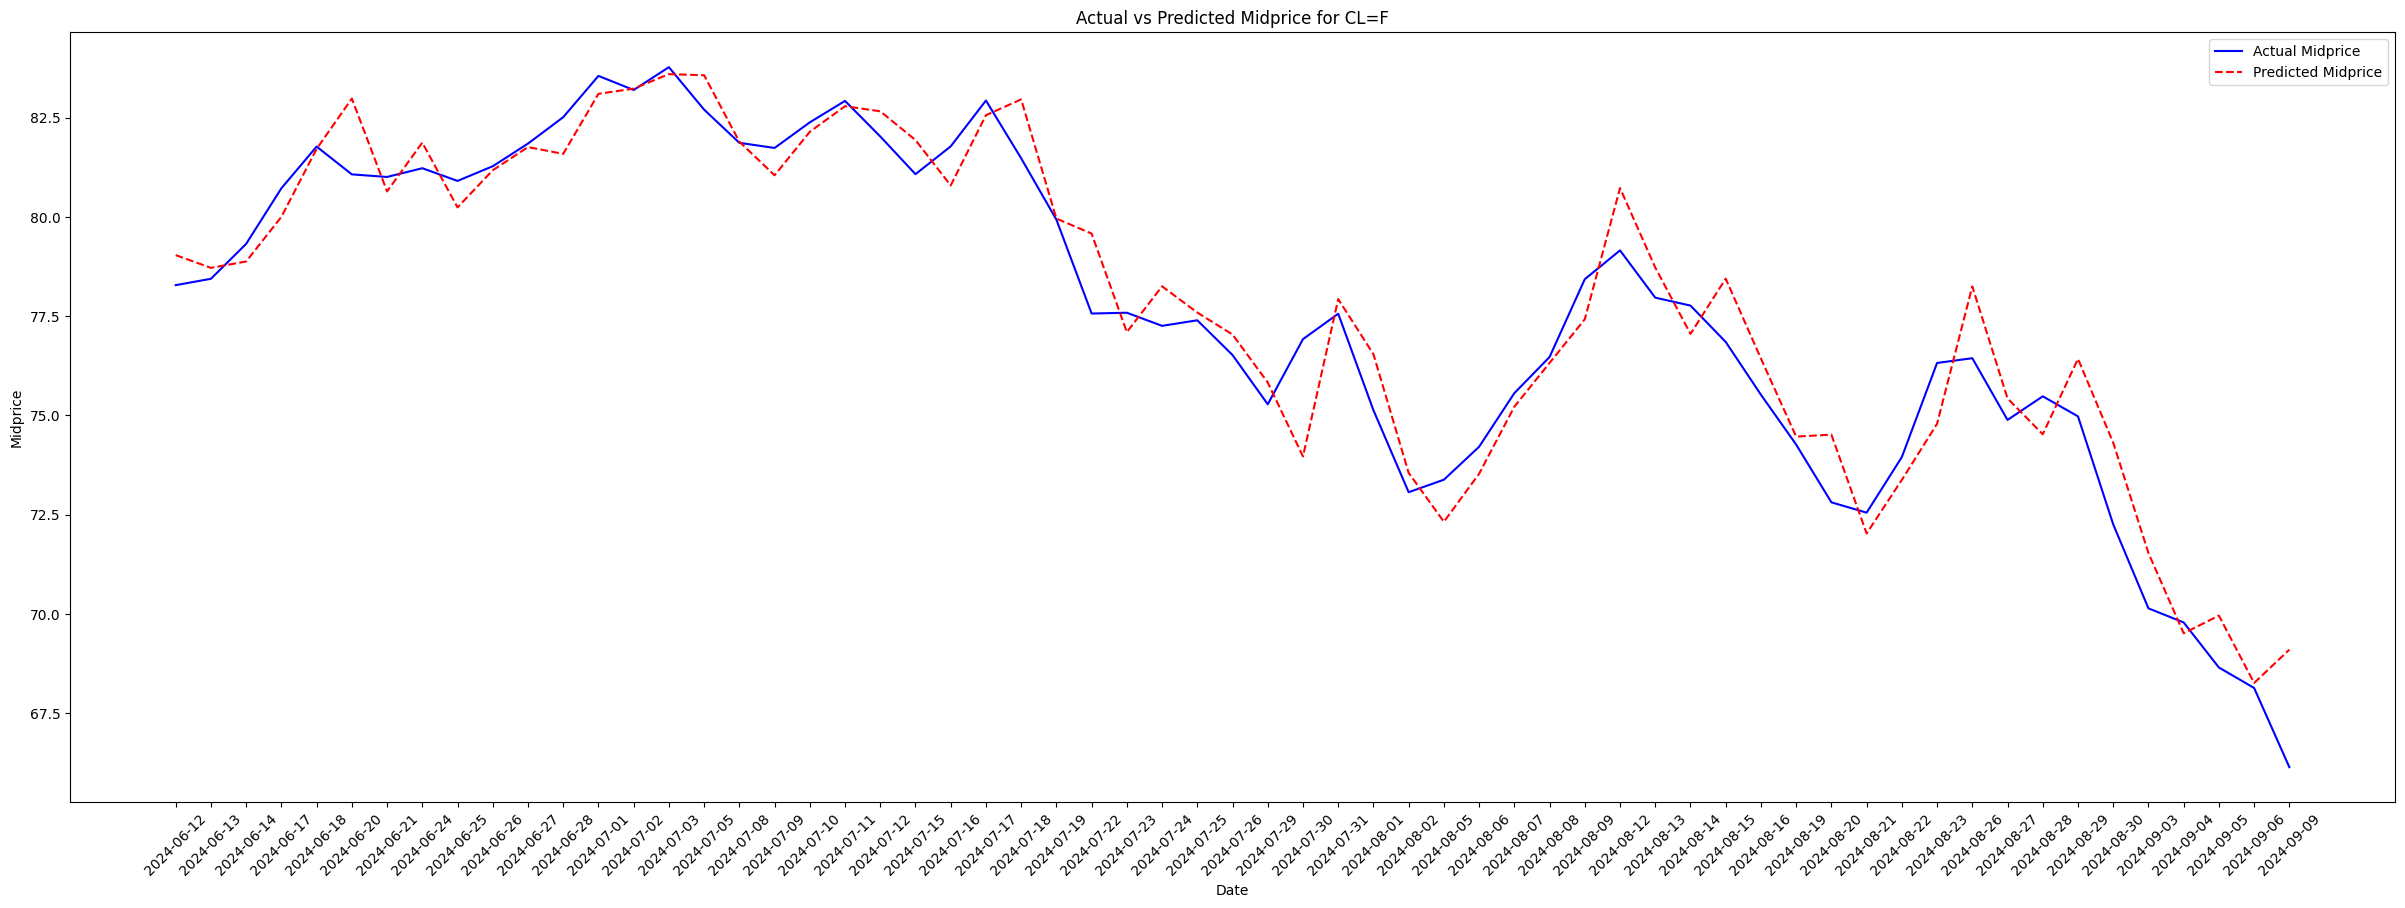

NVDA at 2024-06-12 , Actual Price: 3.7550048828125, xbregressor_result: [2.6289136], xbclassifier_result: -1, final: [2.6289136]
NVDA at 2024-06-13 , Actual Price: 2.0999984741210938, xbregressor_result: [3.3196652], xbclassifier_result: [1], final: [3.3196652]
NVDA at 2024-06-14 , Actual Price: 1.0749969482421875, xbregressor_result: [2.82326], xbclassifier_result: [1], final: [2.82326]
NVDA at 2024-06-17 , Actual Price: 1.8550033569335935, xbregressor_result: [2.212418], xbclassifier_result: [1], final: [2.212418]
NVDA at 2024-06-18 , Actual Price: 1.6299972534179688, xbregressor_result: [2.3022935], xbclassifier_result: [1], final: [2.3022935]
NVDA at 2024-06-20 , Actual Price: -7.674995422363281, xbregressor_result: [2.212418], xbclassifier_result: [1], final: [2.212418]
NVDA at 2024-06-21 , Actual Price: -6.215003967285156, xbregressor_result: [3.3177364], xbclassifier_result: [1], final: [3.3177364]
NVDA at 2024-06-24 , Actual Price: 1.6599998474121094, xbregressor_result: [3.383

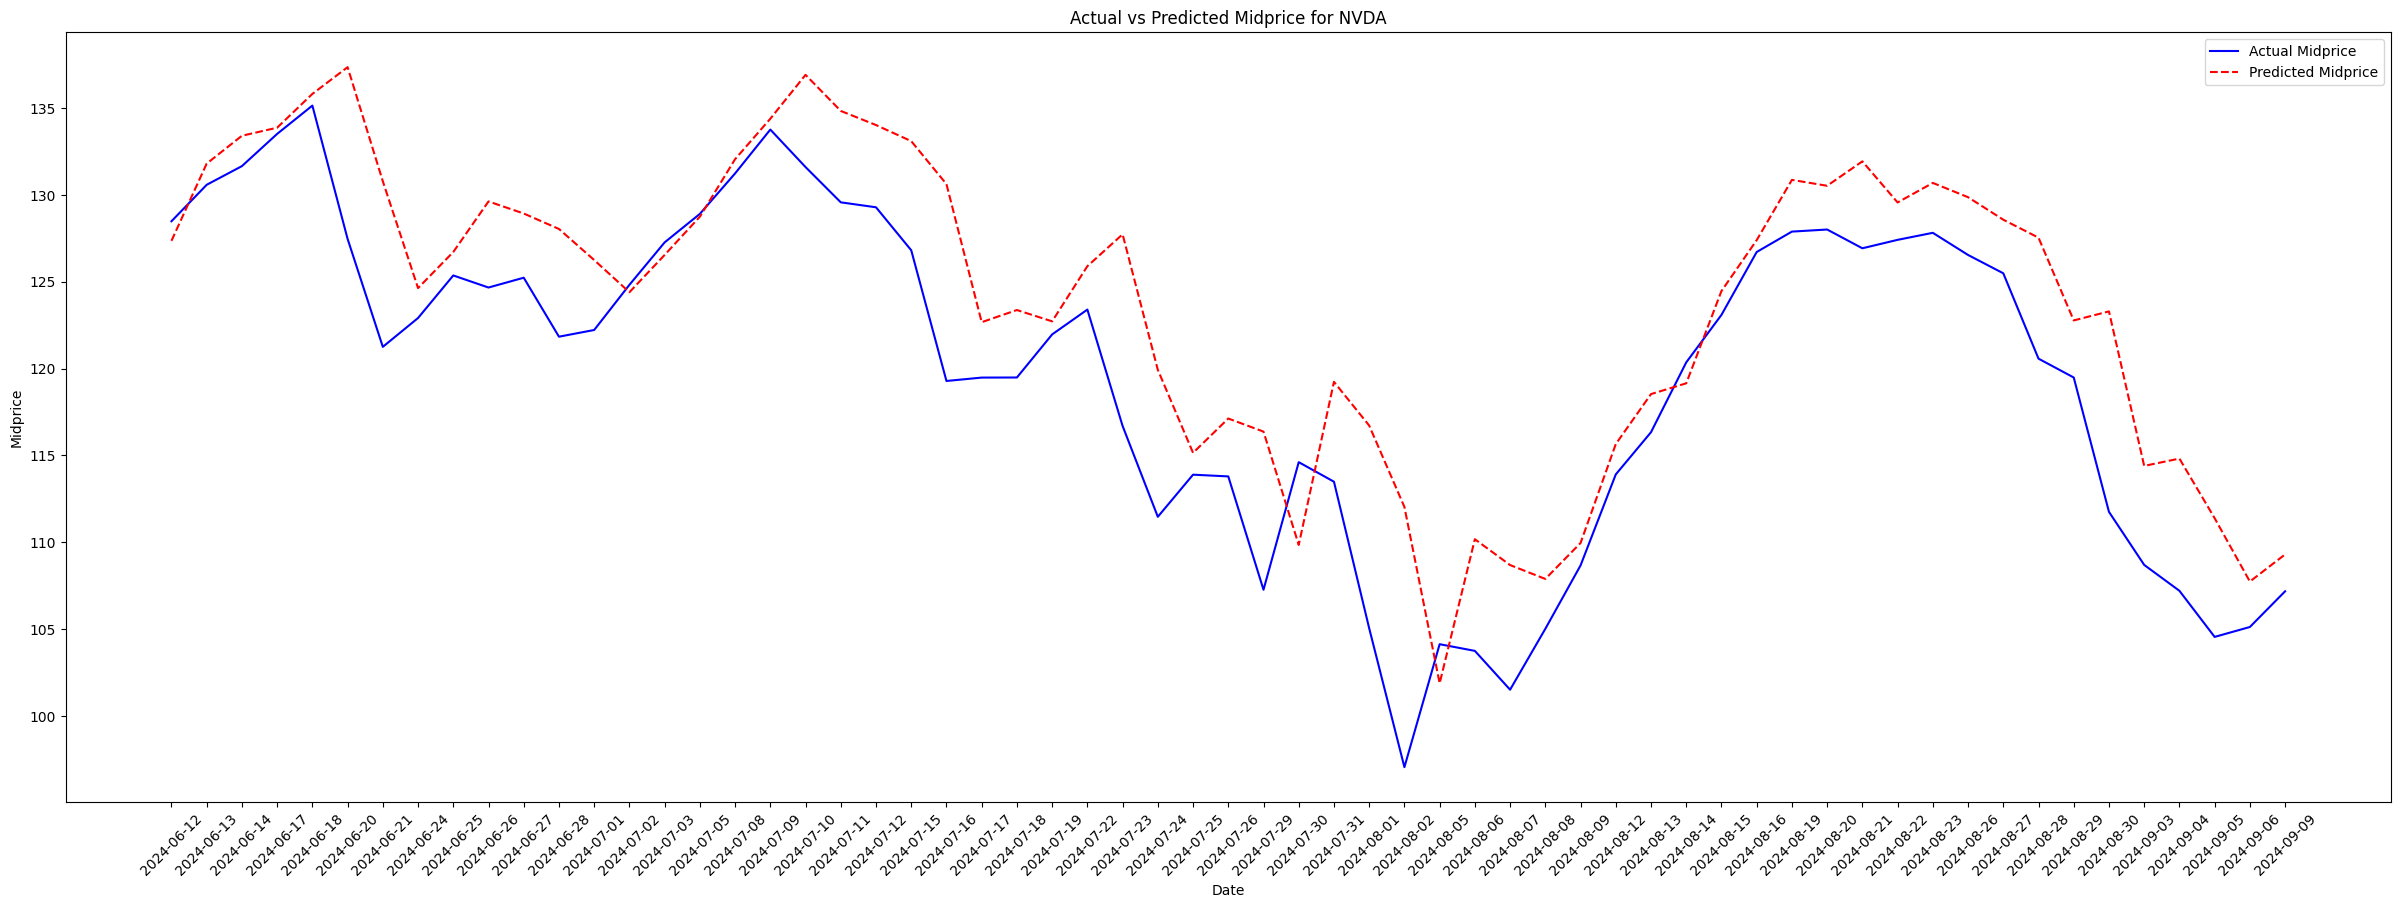

SGDUSD=X at 2024-06-13 , Actual Price: -0.0023589730262756, xbregressor_result: [3.858202e-05], xbclassifier_result: -1, final: [3.858202e-05]
SGDUSD=X at 2024-06-14 , Actual Price: -7.605552673339844e-05, xbregressor_result: [3.858202e-05], xbclassifier_result: [1], final: [3.858202e-05]
SGDUSD=X at 2024-06-17 , Actual Price: 1.7404556274414062e-05, xbregressor_result: [3.858202e-05], xbclassifier_result: [1], final: [3.858202e-05]
SGDUSD=X at 2024-06-18 , Actual Price: 0.001173049211502, xbregressor_result: [3.858202e-05], xbclassifier_result: [1], final: [3.858202e-05]
SGDUSD=X at 2024-06-19 , Actual Price: -0.0008939206600189, xbregressor_result: [3.858202e-05], xbclassifier_result: [1], final: [3.858202e-05]
SGDUSD=X at 2024-06-20 , Actual Price: -0.0010221302509307, xbregressor_result: [3.858202e-05], xbclassifier_result: -1, final: [3.858202e-05]
SGDUSD=X at 2024-06-21 , Actual Price: 0.0002277195453643, xbregressor_result: [3.858202e-05], xbclassifier_result: [1], final: [3.858

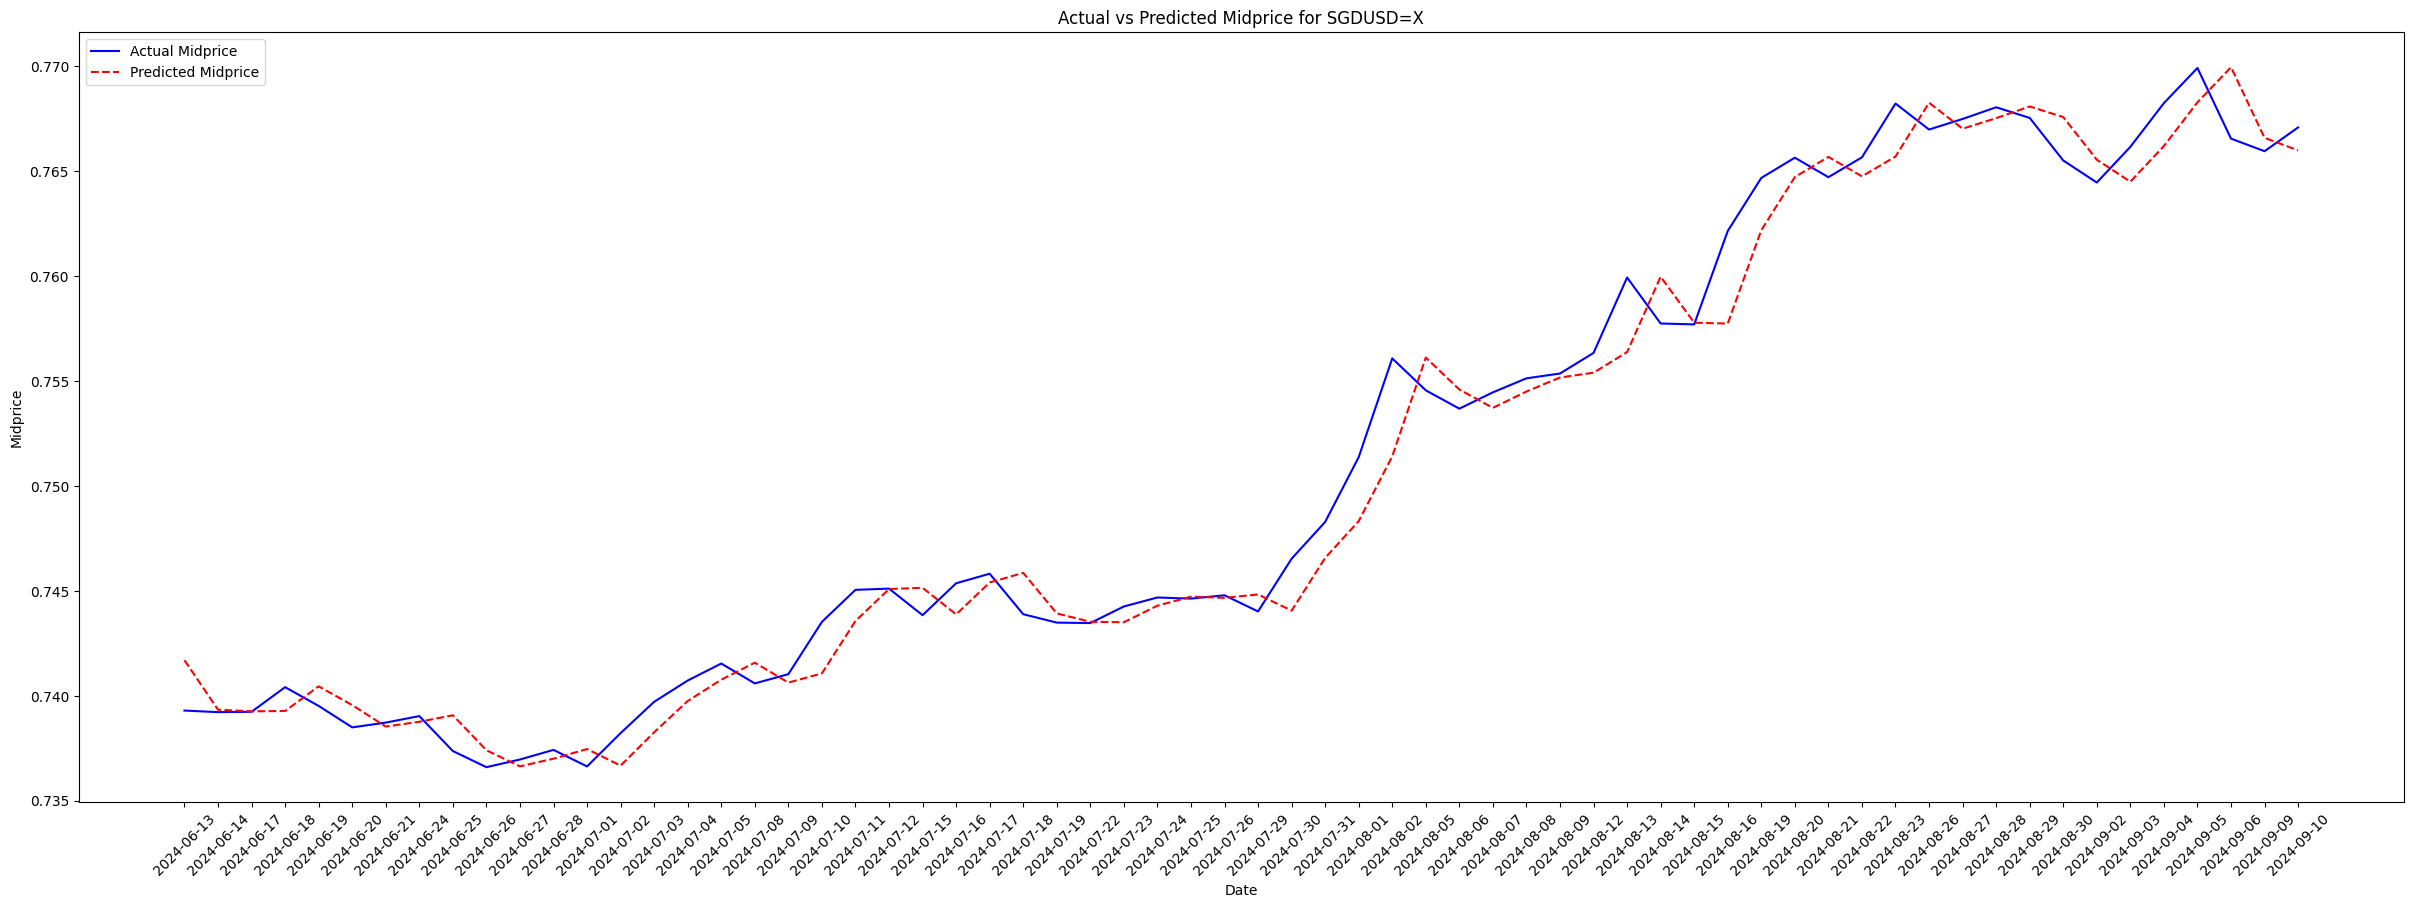

USDSGD=X at 2024-06-13 , Actual Price: 0.0043050646781921, xbregressor_result: [-6.8634974e-05], xbclassifier_result: [1], final: [-6.8634974e-05]
USDSGD=X at 2024-06-14 , Actual Price: 0.0001349449157714, xbregressor_result: [-6.8634974e-05], xbclassifier_result: -1, final: [-6.8634974e-05]
USDSGD=X at 2024-06-17 , Actual Price: -2.992153167724609e-05, xbregressor_result: [-6.8634974e-05], xbclassifier_result: -1, final: [-6.8634974e-05]
USDSGD=X at 2024-06-18 , Actual Price: -0.0021450519561767, xbregressor_result: [-6.8634974e-05], xbclassifier_result: -1, final: [-6.8634974e-05]
USDSGD=X at 2024-06-19 , Actual Price: 0.0016350150108337, xbregressor_result: [-6.8634974e-05], xbclassifier_result: -1, final: [-6.8634974e-05]
USDSGD=X at 2024-06-20 , Actual Price: 0.0018699765205383, xbregressor_result: [-6.8634974e-05], xbclassifier_result: [1], final: [-6.8634974e-05]
USDSGD=X at 2024-06-21 , Actual Price: -0.0004149675369262, xbregressor_result: [-6.8634974e-05], xbclassifier_result

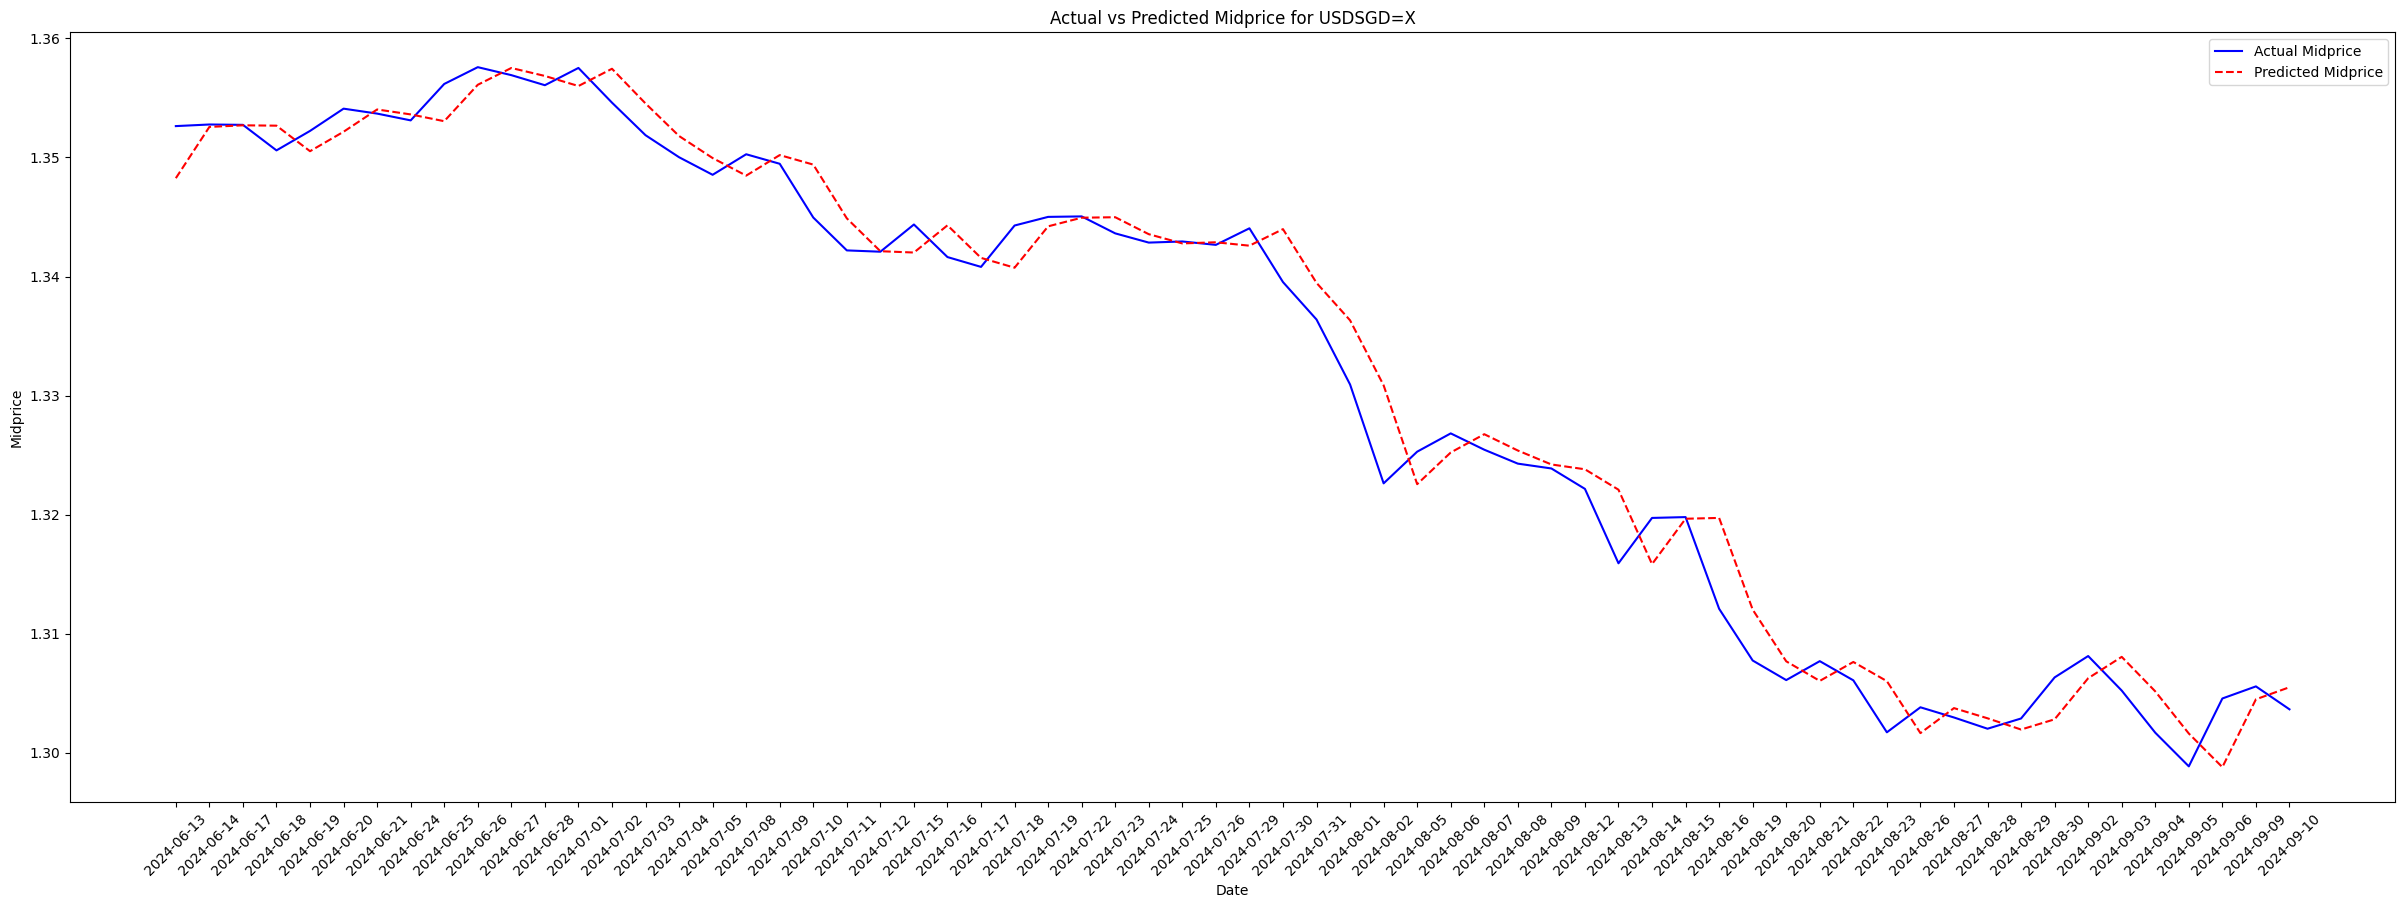

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the necessary functions defined elsewhere:
# xbclassifier_predict, xbregressor_predict, root_mean_squared_error

for ticker_symbol in ticker_list:
    dataframe = pd.read_csv(f"../data/test/{ticker_symbol}.csv")

    X = dataframe.copy(deep=True)

    # Drop columns from index 7 to 72
    #X.drop(X.columns[73:93], axis=1, inplace=True)
    #X.drop(X.columns[7:73], axis=1, inplace=True)
    
    # Drop the specified columns from X
    X.drop(columns=[
        'NEXT_DAY_CLOSEPRICE', 'DAILY_CLOSEPRICE_CHANGE', 'DAILY_CLOSEPRICE_CHANGE_PERCENT', 'DAILY_CLOSEPRICE_DIRECTION',
        'DAILY_MIDPRICE', 'NEXT_DAY_MIDPRICE', 'DAILY_MIDPRICE_CHANGE', 'DAILY_MIDPRICE_CHANGE_PERCENT', 'DAILY_MIDPRICE_DIRECTION', 
        'Date'
    ], inplace=True)


    sign_correct = 0
    total_predictions = 0
    actual_changes = []
    predicted_changes = []
    predicted_midprice = []

    # Loop through the dataframe starting from row 31 (index 30) to the second-to-last row
    for index, row in X.iloc[30:-1].iterrows():
        row_data = row.to_frame().T.reset_index(drop=True)  # Convert row to DataFrame and reset index
        
        xbclassifier_result = xbclassifier_predict(row_data, ticker_symbol)
        if xbclassifier_result == 0:
            xbclassifier_result = -1  # Adjust predicted_sign if it is 0
        
        xbregressor_result = xbregressor_predict(row_data, ticker_symbol)
        #predicted_value = abs(xbregressor_result) * xbclassifier_result
        predicted_value = xbregressor_result
        
        predicted_midprice.append(dataframe.iloc[index]['DAILY_MIDPRICE'] + predicted_value)

        actual_change = dataframe.iloc[index]['DAILY_MIDPRICE_CHANGE']
        actual_sign = np.sign(actual_change)
        
        # Collect actual and predicted changes for RMSE calculation
        actual_changes.append(actual_change)
        predicted_changes.append(predicted_value)

        #predicted_sign = xbclassifier_result
        predicted_sign = np.sign(xbregressor_result)
        
        # Check if the predicted sign matches the actual sign
        if predicted_sign == actual_sign:
            sign_correct += 1
        total_predictions += 1

        print(f"{ticker_symbol} at {dataframe.iloc[index]['Date']} , Actual Price: {actual_change}, xbregressor_result: {xbregressor_result}, xbclassifier_result: {xbclassifier_result}, final: {predicted_value}")

    # Calculate sign accuracy
    sign_accuracy = sign_correct / total_predictions
    print(f"{ticker_symbol} Sign Accuracy: {sign_accuracy}")

    # Calculate RMSE
    rmse = root_mean_squared_error(actual_changes, predicted_changes)
    print(f"{ticker_symbol} RMSE: {rmse}")

    # Predict the last entry
    last_row = X.iloc[-1].to_frame().T.reset_index(drop=True)
    last_xbclassifier_result = xbclassifier_predict(last_row, ticker_symbol)
    if last_xbclassifier_result == 0:
        last_xbclassifier_result = -1  # Adjust predicted_sign if it is 0
    
    last_xbregressor_result = xbregressor_predict(last_row, ticker_symbol)
    last_predicted_value = abs(last_xbregressor_result) * last_xbclassifier_result 

    print(f"{ticker_symbol} at {dataframe.iloc[-1]['Date']} , Predicted Price: {last_predicted_value}")

    # Plotting the results for each ticker
    plt.figure(figsize=(30, 10))

    # Plot actual midprice
    plt.plot(dataframe.iloc[30:-1]['Date'], dataframe.iloc[30:-1]['NEXT_DAY_MIDPRICE'], label='Actual Midprice', color='blue')

    # Plot predicted midprice
    plt.plot(dataframe.iloc[30:-1]['Date'], predicted_midprice, label='Predicted Midprice', color='red', linestyle='--')

    # Add title and labels
    plt.title(f'Actual vs Predicted Midprice for {ticker_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Midprice')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

